In [1]:
from util.graph import read_bart

# Pre-process dataset
# 1. Read data from disk
# 2. Drop origin column, we don't need it
# 3. Sum all passengers arriving at the destination per timestamp
raw = read_bart(2022) \
    .drop(columns=['origin']) \
    .groupby(['datetime', 'destination']).sum()

raw

passengers
datetime            destination            
2022-01-01 00:00:00 12                   19
                    16                   25
                    19                   24
                    24                   26
                    AN                   10
...                                     ...
2022-12-31 23:00:00 UC                   13
                    WC                   33
                    WD                   19
                    WP                   15
                    WS                    7

[374120 rows x 1 columns]

In [2]:
from datetime import datetime, timedelta

import pandas as pd

# Reindex in order to fill the missing gaps (important for Time Series Analysis or Forecasting)
start_date = datetime(2022, 1, 1)
end_date = datetime(2023, 1, 1)
date_range = end_date - start_date
index = pd.MultiIndex.from_tuples([
            (start_date + timedelta(hours=h), dest)
            for dest in raw.index.droplevel(0).unique()
            for h in range(0, date_range.days * 24 + date_range.seconds // 3600)],
            names=['datetime', 'station'])
data = raw.reindex(index).sort_index()

# Fill empty values (NaN) with 0.0
data.fillna(0.0, inplace=True)

data['hour'] = data.index.to_series().apply(lambda idx: idx[0].hour)
data['weekday'] = data.index.to_series().apply(lambda idx: ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'][idx[0].weekday()])

data

passengers  hour   weekday
datetime            station                            
2022-01-01 00:00:00 12             19.0     0  Saturday
                    16             25.0     0  Saturday
                    19             24.0     0  Saturday
                    24             26.0     0  Saturday
                    AN             10.0     0  Saturday
...                                 ...   ...       ...
2022-12-31 23:00:00 UC             13.0    23  Saturday
                    WC             33.0    23  Saturday
                    WD             19.0    23  Saturday
                    WP             15.0    23  Saturday
                    WS              7.0    23  Saturday

[438000 rows x 3 columns]

In [3]:
from parallel_pandas import ParallelPandas
from tqdm.notebook import tqdm

tqdm.pandas()
ParallelPandas.initialize()


def remove_trend(df: pd.DataFrame) -> pd.Series:
    from statsmodels.tsa.stl._stl import STL

    stl_fit = STL(df.passengers,
                  period=3,
                  low_pass=5,
                  robust=True).fit()

    return stl_fit.trend


# Detect trend
normalized = data.assign(trend=data
                         .groupby(['station', 'weekday', 'hour']).p_apply(remove_trend)
                         .droplevel([0, 1, 2]))

normalized['normalized'] = normalized.passengers - normalized.trend
normalized['mean'] = normalized.groupby(['station', 'weekday', 'hour']).apply(lambda df: df.normalized.mean() + df.trend).droplevel([0, 1, 2])
normalized['threshold'] = normalized.groupby(['station', 'weekday', 'hour']).apply(lambda df: df.normalized.quantile(0.9) + df.trend).droplevel([0, 1, 2])
normalized['extra'] = normalized.apply(lambda row: row.passengers - row['mean'] if row.passengers > row.threshold else 0.0, axis=1)

normalized

REMOVE_TREND DONE:   0%|          | 0/8400 [00:00<?, ?it/s]

passengers  hour   weekday      trend   
datetime            station                                          
2022-01-01 00:00:00 12             19.0     0  Saturday  15.604675  \
                    16             25.0     0  Saturday  23.446323   
                    19             24.0     0  Saturday  17.532903   
                    24             26.0     0  Saturday  12.845188   
                    AN             10.0     0  Saturday  19.985684   
...                                 ...   ...       ...        ...   
2022-12-31 23:00:00 UC             13.0    23  Saturday  12.324305   
                    WC             33.0    23  Saturday  18.988889   
                    WD             19.0    23  Saturday  35.444319   
                    WP             15.0    23  Saturday  16.042380   
                    WS              7.0    23  Saturday   0.324947   

                             normalized       mean  threshold      extra  
datetime            station                                               
2022-01-01 00:00:00 12         3.395325  19.243464  30.744761   0.000000  
                    16         1.553677  29.063544  51.401433   0.000000  
                    19         6.467097  22.846374  36.282163   0.000000  
                    24        13.154812  18.167587  44.598747   0.000000  
                    AN        -9.985684  21.210516  36.338237   0.000000  
...                                 ...        ...        ...        ...  
2022-12-31 23:00:00 UC         0.675695  12.700380  28.876071   0.000000  
                    WC        14.011111  18.655683  30.918668  14.344317  
                    WD       -16.444319  34.215953  46.463806   0.000000  
                    WP        -1.042380  15.333495  26.157762   0.000000  
                    WS         6.675053   2.949630   8.209737   0.000000  

[438000 rows x 8 columns]

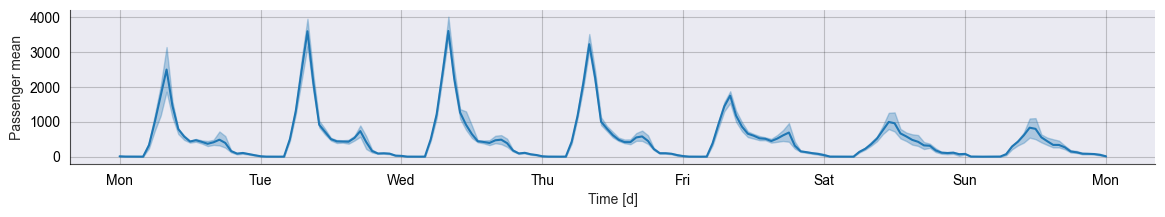

In [4]:
from matplotlib.ticker import MultipleLocator
from util.plotstyle import style_plot
from datetime import datetime
from matplotlib.dates import DateFormatter

import matplotlib.pyplot as plt
import seaborn as sns

regularity_example = normalized.assign(
    lower=normalized.groupby(['station', 'weekday', 'hour']).apply(lambda df: df.normalized.quantile(0.1) + df.trend).droplevel([0, 1, 2]),
    upper=normalized.groupby(['station', 'weekday', 'hour']).apply(lambda df: df.normalized.quantile(0.9) + df.trend).droplevel([0, 1, 2])
)[['mean', 'lower', 'upper']]
regularity_example = regularity_example.swaplevel().loc['EM'].loc[datetime(2022, 7, 4):datetime(2022, 7, 11)]

fig, axes = plt.subplots(1, 1, figsize=(14, 2))

axes.fill_between(
    regularity_example.index.to_series(),
    regularity_example['upper'],
    regularity_example['lower'],
    color='tab:blue',
    alpha=0.3
)
sns.lineplot(regularity_example['mean'])

axes.set_xlabel('Time [d]')
axes.set_ylabel('Passenger mean')
axes.xaxis.set_major_formatter(DateFormatter("%a"))
axes.yaxis.set_major_locator(MultipleLocator(1000))

style_plot(axes)

plt.savefig('figures/flow-regularity-EM.png', dpi=300, bbox_inches='tight', transparent=True)

Event passengers: 10239.95


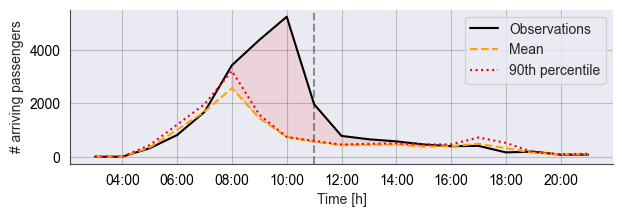

In [5]:
from util.plotstyle import style_plot
import matplotlib.pyplot as plt
import seaborn as sns

# Show an example of normalization and outlier detection
fig, axes = plt.subplots(1, 1, figsize=(7, 2))
normalized_example = normalized.loc[datetime(2022, 6, 20, 3):datetime(2022, 6, 20, 21)].swaplevel().loc['EM'].copy()

axes.axvline(x=datetime(2022, 6, 20, 11),
             alpha=0.4,
             color='black',
             linestyle='dashed')

axes.fill_between(normalized_example.passengers.index.to_series(),
                  normalized_example.passengers, normalized_example['mean'],
                  where=(normalized_example.passengers > normalized_example['mean']),
                  color='red',
                  alpha=0.1)

sns.lineplot(normalized_example.passengers,
             color='black',
             label='Observations')
sns.lineplot(normalized_example['mean'],
             color='orange',
             linestyle='dashed',
             label='Mean')
sns.lineplot(normalized_example.threshold,
             color='red',
             linestyle='dotted',
             label='90th percentile')

axes.set_xlabel('Time [h]')
axes.set_ylabel('# arriving passengers')

axes.xaxis.set_major_formatter(DateFormatter("%H:%M"))

style_plot(axes)

print(f'Event passengers: {normalized_example.loc[datetime(2022, 6, 20, 7):datetime(2022, 6, 20, 13)].extra.sum():.2f}')

plt.savefig('figures/event-flow-example-20220620-EM.png', dpi=300, bbox_inches='tight', transparent=True)

In [150]:
from util.event import EVENT_TYPE_MAP
import math
from util.graph import read_stations

# Load data needed to parse events
events = pd.read_csv('data/events.csv')
stations = read_stations().set_index('codes')
venue_data = pd.read_csv('data/venue_capacity.csv', delimiter=';').set_index('venue')

# Correct event type column
events['event_type'] = events.event_type.map(lambda t: EVENT_TYPE_MAP[t] if t in EVENT_TYPE_MAP else None)

# Parse datetime columns and drop invalid values
events['datetime'] = events.start_date.map(lambda dt: "-".join(dt.split("-")[:-1]).replace("T", " "))
events['datetime'] = events.datetime.map(lambda dt: None if dt == '' else datetime.strptime(dt, '%Y-%m-%d %H:%M'))
events = events[events.datetime != None][['datetime', 'name', 'event_type', 'venue', 'latitude', 'longitude']].dropna()
events['datetime'] = events.datetime.map(lambda dt: datetime(dt.year, dt.month, dt.day, dt.hour))

# Match venue to their capacity
events['capacity'] = events['venue'].map(lambda venue: venue_data.loc[venue].capacity if venue in venue_data.index else None)

# Map to nearest metro station
events['station'] = events.apply(
    lambda event: next(stations.apply(lambda station:math.sqrt(math.pow(event.latitude - station.lat, 2) + math.pow(event.longitude - station.long, 2)) * 6371e3 / 360, axis=1)
                       .sort_values().items()),
    axis=1)
events['distance'] = events.station.apply(lambda station: station[1])
events['station'] = events.station.apply(lambda station: station[0])

# Sort events by date and drop some columns
events = events[['datetime', 'name', 'event_type', 'venue', 'capacity', 'distance', 'station']].sort_values('datetime', ascending=True)

# Discard events not in 2022
events = events[(events.datetime >= datetime(2022, 1, 1)) & (events.datetime < datetime(2023, 1, 1))]

# Discard duplicates
events.drop_duplicates(['datetime', 'venue'], inplace=True)

events

,datetime,name,event_type,venue,capacity,distance,station
24,2022-01-01 04:00:00,It's A New Day + Breakfast Of Champions Block ...,party,Monarch,300,60.536872,PL
3,2022-01-01 04:00:00,It's A New Day + Breakfast Of Champions Block ...,music,The Great Northern,700,237.901186,16
16,2022-01-01 10:00:00,"Annual Hangover Brunch! Biscuits + Gravy, Eggs...",music,Rio Nido Roadhouse,None,15141.116884,RM
10,2022-01-01 11:00:00,New Years Day Polar Plunge + Naked Bike Ride,experiences,Ocean Beach,None,1370.383512,DC
37,2022-01-01 14:00:00,The Apartment,film,Alamo Drafthouse Cinema,150,71.384850,24
...,...,...,...,...,...,...,...
35707,2022-12-31 22:00:00,SIDEPIECE New Year's Eve,music,Temple,1100,76.854115,MT
35690,2022-12-31 22:00:00,Greg Proops,comedy,Punch Line San Francisco,240,71.886606,EM
35687,2022-12-31 22:00:00,Anthony Hamilton,music,Paramount Theatre,3040,17.161968,19
35696,2022-12-31 22:00:00,Comedy Countdown: New Year's Eve Countdown Show,comedy,Cobb's Comedy Club,400,334.059840,MT


In [151]:
event_flow = events.assign(
    passengers=events.apply(
        lambda event: normalized
                      .loc[event.datetime-timedelta(hours=4):event.datetime+timedelta(hours=2)]
                      .swaplevel().loc[event.station]
                      .extra.sum(),
        axis=1),
    mean_flow=events.apply(
        lambda event: normalized
                      .loc[event.datetime-timedelta(hours=4):event.datetime+timedelta(hours=2)]
                      .swaplevel().loc[event.station]
                      ['mean'].sum(),
        axis=1)
)

event_flow.sort_values('passengers', ascending=False)

,datetime,name,event_type,venue,capacity,distance,station,passengers,mean_flow
16172,2022-06-26 14:00:00,"Author: Sherilyn Connelly, Beautiful Ghosts",education,San Francisco Public Library,None,39.889256,CC,15370.527241,2576.472759
16141,2022-06-26 14:00:00,Chamber Music,music,Davies Symphony Hall,2743,110.795114,CC,15370.527241,2576.472759
16122,2022-06-26 12:00:00,Pride Sunday,party,The Lone Star Saloon,-,140.328044,CC,13310.815275,2393.184725
16094,2022-06-26 13:00:00,Alphabet Soup: A Trans Arcade Mixer,lgbtq,Hotel Zetta,175,22.567664,PL,7154.405337,3693.594663
26758,2022-10-08 11:00:00,Watch Party Fleet Week,experiences,Aquarium of The Bay,None,350.014424,EM,5935.355732,4199.644268
...,...,...,...,...,...,...,...,...,...
13762,2022-06-04 13:00:00,Minted,music,The San Francisco Mint,None,32.310186,PL,0.000000,4695.975700
13715,2022-06-04 14:00:00,"Fantasy Island ft. Daniel Bell, Rooz, J-KIND +...",music,The Midway,2500,576.442979,24,0.000000,1741.525192
13820,2022-06-04 14:00:00,THE DePRIEST INCIDENT by Charles White,arts,Museum of the African Diaspora (MOAD),125,49.519867,MT,0.000000,2681.672383
13813,2022-06-05 03:00:00,Klein International String Competition,music,San Francisco Conservatory of Music,None,138.000979,CC,-0.013115,139.731529


In [152]:
def filter_concurrent_events(df: pd.DataFrame):
    return df[df.apply(lambda event: df[(df.datetime >= event.datetime-timedelta(hours=4)) & (df.datetime <= event.datetime+timedelta(hours=2)) & (df.capacity > event.capacity)].shape[0] == 0, axis=1)]


# Parse event venue capacity field
filtered_events = event_flow \
    .assign(capacity=event_flow.capacity.apply(lambda cap: cap if cap != '-' else None)) \
    .dropna().astype({'capacity': 'int'})

# Filter insignificant / unrealistic observations
filtered_events = filtered_events[filtered_events.passengers <= filtered_events.capacity]
filtered_events = filtered_events[filtered_events.passengers > 50]

# Filter multiple events that occur within a short timespan
filtered_events = filtered_events.groupby('station').apply(filter_concurrent_events).reset_index(drop=True)

# Determine which events types are relevant
event_type_significance = filtered_events.groupby('event_type').apply(lambda df: df.passengers.sum())
event_types = event_type_significance[event_type_significance >= 1000]

# Drop non-relevant event types
unfiltered_events = filtered_events.copy()
filtered_events = filtered_events.copy()[filtered_events.event_type.apply(lambda t: t in event_types)]

# Add extra data fields
filtered_events['relative_capacity'] = filtered_events.capacity / filtered_events.mean_flow

filtered_events

,datetime,name,event_type,venue,capacity,distance,station,passengers,mean_flow,relative_capacity
0,2022-01-03 19:00:00,Laugh Out Loud Starring Bet/Hbo Jay Lamont,music,Yoshi's Oakland,310,177.558162,12,75.916155,561.449594,0.552142
1,2022-01-10 19:00:00,Rick Estrin & The Nightcats,music,Yoshi's Oakland,310,177.558162,12,97.437890,624.115581,0.496703
2,2022-02-18 21:00:00,Wastewalker + Ominous Ruin + The Last Of Lucy ...,music,The Golden Bull,150,26.042526,12,53.199726,845.275670,0.177457
3,2022-02-19 20:00:00,Mentor + Denial Of Life + Earth Exit + Rapid R...,music,The Golden Bull,150,26.042526,12,137.063446,733.756733,0.204427
4,2022-02-20 20:00:00,Owen Adair Kelley + Zache Davis + Yea Ming And...,music,The Golden Bull,150,26.042526,12,58.527144,448.551497,0.334410
...,...,...,...,...,...,...,...,...,...,...
1168,2022-12-18 21:00:00,Werd. | Joey Alaniz + Dino Velvet (Common Ground),music,Monarch,300,60.536872,PL,172.560789,1324.001596,0.226586
1169,2022-12-20 20:00:00,"Dazmin D'Leon, Ditch The Ego, G.M.E. Yung Mac",music,Bottom Of The Hill,350,399.806396,PL,162.528735,2401.923469,0.145717
1170,2022-12-22 21:00:00,SAFARI | Latin Night,music,LOVE + PROPAGANDA,400,82.415284,PL,181.937483,1991.679100,0.200836
1171,2022-12-23 22:00:00,SNBRN: Ugly Sweater Party,music,1015 Folsom,900,117.397934,PL,89.939657,1433.585021,0.627797


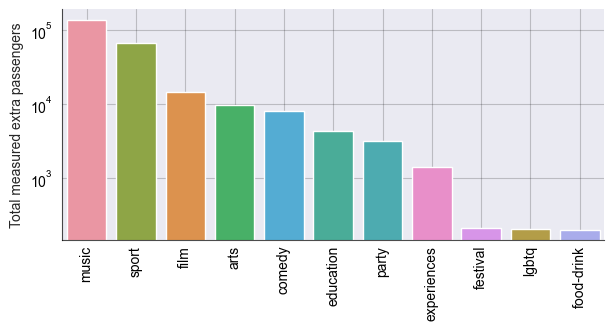

In [159]:
fig, axes = plt.subplots(1, 1, figsize=(7, 3))
sns.barplot(unfiltered_events,
            x='event_type', y='passengers',
            hue='event_type',
            order=event_type_significance.sort_values(ascending=False).index.to_series(),
            estimator=sum,
            errorbar=None, dodge=False,
            ax=axes)

axes.set_xlabel(None)
axes.set_ylabel("Total measured extra passengers")

plt.yscale('log')

axes.get_legend().remove()

axes.tick_params(axis='x',
                 rotation=90,
                 pad=0)

style_plot(axes)
plt.savefig('figures/event-types.png', dpi=300, bbox_inches='tight', transparent=True)

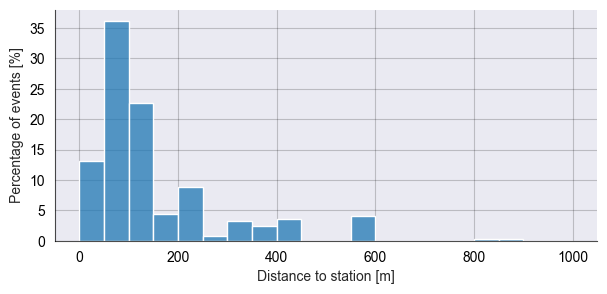

In [160]:
fig, axes = plt.subplots(1, 1, figsize=(7, 3))
sns.histplot(filtered_events.distance, binrange=(0, 1000), binwidth=50, stat='percent', ax=axes)

axes.set_xlabel('Distance to station [m]')
axes.set_ylabel('Percentage of events [%]')

style_plot(axes)
plt.savefig('figures/event-distance.png', dpi=300, bbox_inches='tight', transparent=True)

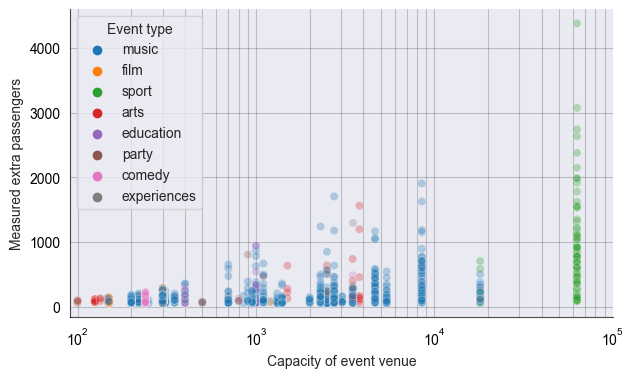

In [162]:
from matplotlib.ticker import LogLocator

fig, axes = plt.subplots(1, 1, figsize=(7, 4))
sns.scatterplot(filtered_events.rename(columns={'event_type': 'Event type'}),
                x='capacity', y='passengers',
                alpha=0.3, hue='Event type',
                ax=axes)
axes.set_xlabel('Capacity of event venue')
axes.set_ylabel('Measured extra passengers')

plt.xscale('log')
axes.set_xlim(91, 10e4+1)
axes.xaxis.set_major_locator(LogLocator(subs='all'))

style_plot(axes)
plt.savefig('figures/event-capacity.png', dpi=300, bbox_inches='tight', transparent=True)

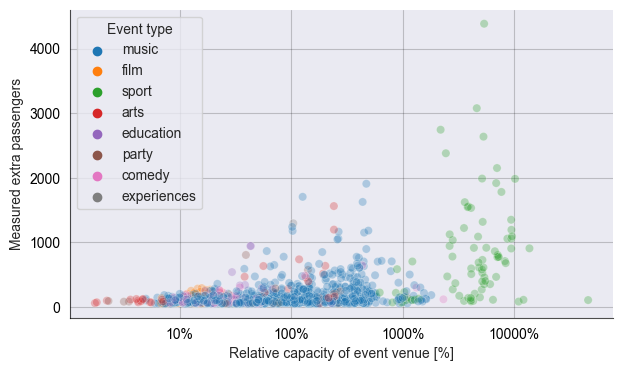

In [158]:
from matplotlib.ticker import PercentFormatter

fig, axes = plt.subplots(1, 1, figsize=(7, 4))
sns.scatterplot(filtered_events.rename(columns={'event_type': 'Event type'}),
                x='relative_capacity', y='passengers',
                alpha=0.3, hue='Event type',
                ax=axes)
axes.set_xlabel('Relative capacity of event venue [%]')
axes.set_ylabel('Measured extra passengers')

plt.xscale('log')
axes.xaxis.set_major_formatter(PercentFormatter(xmax= 1.0))

style_plot(axes)
plt.savefig('figures/event-capacity-relative.png', dpi=300, bbox_inches='tight', transparent=True)